Se importan las librerias 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

##Para obtener los datos de los puntos organizados
def get_oscilloscope(ruta):
    Dataframe=pd.read_csv(ruta)
    Dataframe=Dataframe.iloc[:, 3:5] 
    Dataframe.columns=["Tiempo", "Magnitud"]
    return Dataframe


Carga inductiva

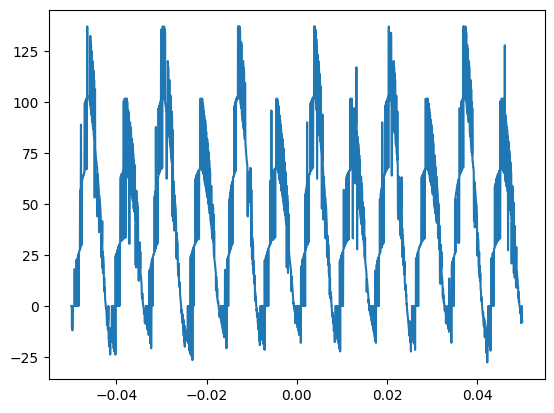

In [10]:
CH1=get_oscilloscope("abanico/CH1.CSV")#Tension en el canal 1/2
CH2=get_oscilloscope("abanico/CH2.CSV")
R=10.4
CURRENT=(CH1.Magnitud-CH2.Magnitud)/R
ACTIVE_POWER=CURRENT*CH1.Magnitud

plt.plot(CH1.Tiempo,ACTIVE_POWER)
